# Is there a correlation between opioid deaths and demographics?

Part 1: Opioid-related deaths

In [6]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from scipy.stats import linregress

# File to Load
drug_deaths_to_load = Path("Data/drug_death_counts.csv")

# Read Drug Overdose Data File and store into Pandas DataFrames
drug_deaths = pd.read_csv(drug_deaths_to_load)

# Preview the Data
drug_deaths

/var/folders/06/x1qqn_713xj3fw1_jjfy1f680000gp/T/ipykernel_92911/2517688977.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  drug_deaths = pd.read_csv(drug_deaths_to_load)


,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Footnote,Footnote Symbol,Predicted Value
0,AK,2015,April,12 month-ending,Natural & semi-synthetic opioids (T40.2),NaN,100,0.000000,Alaska,Numbers may differ from published reports usin...,**,NaN
1,AK,2015,April,12 month-ending,Psychostimulants with abuse potential (T43.6),NaN,100,0.000000,Alaska,Numbers may differ from published reports usin...,**,NaN
2,AK,2015,April,12 month-ending,Number of Drug Overdose Deaths,126,100,0.000000,Alaska,Numbers may differ from published reports usin...,**,126
3,AK,2015,April,12 month-ending,Cocaine (T40.5),NaN,100,0.000000,Alaska,Numbers may differ from published reports usin...,**,NaN
4,AK,2015,April,12 month-ending,"Natural, semi-synthetic, & synthetic opioids, ...",NaN,100,0.000000,Alaska,Numbers may differ from published reports usin...,**,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
66985,YC,2024,January,12 month-ending,"Natural, semi-synthetic, & synthetic opioids, ...","2,527",100,0.290625,New York City,Underreported due to incomplete data.,*,"2,596"
66986,YC,2024,January,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)","2,393",100,0.290625,New York City,Underreported due to incomplete data.,*,"2,467"
66987,YC,2024,January,12 month-ending,Number of Deaths,"55,742",100,0.290625,New York City,Underreported due to incomplete data.,*,NaN
66988,YC,2024,January,12 month-ending,"Natural & semi-synthetic opioids, incl. methad...",677,100,0.290625,New York City,Underreported due to incomplete data.,*,694


In [7]:
# Drop columns by name, inplace
drug_deaths.drop(['Footnote Symbol', 'Footnote', 'Predicted Value','Percent Complete','Percent Pending Investigation','Period'], axis=1, inplace=True)

drug_deaths.head()

,State,Year,Month,Indicator,Data Value,State Name
0,AK,2015,April,Natural & semi-synthetic opioids (T40.2),NaN,Alaska
1,AK,2015,April,Psychostimulants with abuse potential (T43.6),NaN,Alaska
2,AK,2015,April,Number of Drug Overdose Deaths,126,Alaska
3,AK,2015,April,Cocaine (T40.5),NaN,Alaska
4,AK,2015,April,"Natural, semi-synthetic, & synthetic opioids, ...",NaN,Alaska


In [8]:
# Filter the DataFrame to keep only rows where the Indicator is "Opioids (T40.0-T40.4,T40.6)"
opioids_data = drug_deaths[drug_deaths['Indicator'] == 'Opioids (T40.0-T40.4,T40.6)']

opioids_data

,State,Year,Month,Indicator,Data Value,State Name
7,AK,2015,April,"Opioids (T40.0-T40.4,T40.6)",NaN,Alaska
23,AK,2015,August,"Opioids (T40.0-T40.4,T40.6)",NaN,Alaska
35,AK,2015,December,"Opioids (T40.0-T40.4,T40.6)",NaN,Alaska
43,AK,2015,February,"Opioids (T40.0-T40.4,T40.6)",NaN,Alaska
53,AK,2015,January,"Opioids (T40.0-T40.4,T40.6)",NaN,Alaska
...,...,...,...,...,...,...
66941,YC,2023,November,"Opioids (T40.0-T40.4,T40.6)","2,673",New York City
66950,YC,2023,October,"Opioids (T40.0-T40.4,T40.6)","2,760",New York City
66964,YC,2023,September,"Opioids (T40.0-T40.4,T40.6)","2,765",New York City
66969,YC,2024,February,"Opioids (T40.0-T40.4,T40.6)","2,494",New York City


In [9]:
# Count NaN values in all columns
nan_counts = opioids_data.isna().sum()

print("NaN counts for each column:")
print(nan_counts)

# Count total NaN values in the entire DataFrame
total_nan = opioids_data.isna().sum().sum()

print(f"\nTotal NaN values in the dataset: {total_nan}")

# Count NaN values specifically in the 'Data Value' column
data_value_nan = opioids_data['Data Value'].isna().sum()

print(f"\nNaN values in 'Data Value' column: {data_value_nan}")

# Calculate percentage of NaN values in 'Data Value' column
percent_nan = (data_value_nan / len(opioids_data)) * 100

print(f"Percentage of NaN values in 'Data Value' column: {percent_nan:.2f}%")

NaN counts for each column:
State            0
Year             0
Month            0
Indicator        0
Data Value    1188
State Name       0
dtype: int64

Total NaN values in the dataset: 1188

NaN values in 'Data Value' column: 1188
Percentage of NaN values in 'Data Value' column: 21.60%


In [10]:
# Get unique values in the 'State Name' column
unique_states = opioids_data['State Name'].unique()

# Print the unique state names
print("States listed in the State Name column:")
for state in sorted(unique_states):
    print(state)

# Get the count of unique states
num_states = len(unique_states)
print(f"\nTotal number of unique states: {num_states}")

# This Dataset does not report data for Louisiana, Nebraska, and Pennsylvania

States listed in the State Name column:
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nevada
New Hampshire
New Jersey
New Mexico
New York
New York City
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
United States
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming

Total number of unique states: 50


In [11]:
# Count rows before dropping
rows_before = len(opioids_data)

# Drop rows where 'Data Value' is NaN
opioids_data_clean = opioids_data.dropna(subset=['Data Value'])

# Count rows after dropping
rows_after = len(opioids_data_clean)

# Print results
print(f"Rows before dropping NaN values: {rows_before}")
print(f"Rows after dropping NaN values: {rows_after}")
print(f"Number of rows dropped: {rows_before - rows_after}")

# Verify that there are no more NaN values in 'Data Value' column
nan_count = opioids_data_clean['Data Value'].isna().sum()
print(f"NaN values remaining in 'Data Value' column: {nan_count}")

Rows before dropping NaN values: 5500
Rows after dropping NaN values: 4312
Number of rows dropped: 1188
NaN values remaining in 'Data Value' column: 0


In [12]:
# Print DataFrame
opioids_data_clean

,State,Year,Month,Indicator,Data Value,State Name
117,AK,2015,November,"Opioids (T40.0-T40.4,T40.6)",79,Alaska
130,AK,2015,October,"Opioids (T40.0-T40.4,T40.6)",86,Alaska
151,AK,2016,April,"Opioids (T40.0-T40.4,T40.6)",95,Alaska
165,AK,2016,August,"Opioids (T40.0-T40.4,T40.6)",100,Alaska
179,AK,2016,December,"Opioids (T40.0-T40.4,T40.6)",96,Alaska
...,...,...,...,...,...,...
66941,YC,2023,November,"Opioids (T40.0-T40.4,T40.6)","2,673",New York City
66950,YC,2023,October,"Opioids (T40.0-T40.4,T40.6)","2,760",New York City
66964,YC,2023,September,"Opioids (T40.0-T40.4,T40.6)","2,765",New York City
66969,YC,2024,February,"Opioids (T40.0-T40.4,T40.6)","2,494",New York City


In [13]:
# First, make an explicit copy to ensure we're working with a new DataFrame
opioids_data_clean = opioids_data_clean.copy()

# Count occurrences before replacement
yc_count_before = (opioids_data_clean['State'] == 'YC').sum()
nyc_count_before = (opioids_data_clean['State Name'] == 'New York City').sum()

# Replace 'YC' with 'NY' in the 'State' column
opioids_data_clean.loc[opioids_data_clean['State'] == 'YC', 'State'] = 'NY'

# Replace 'New York City' with 'New York' in the 'State Name' column
opioids_data_clean.loc[opioids_data_clean['State Name'] == 'New York City', 'State Name'] = 'New York'

# Count occurrences after replacement
ny_count_after = (opioids_data_clean['State'] == 'NY').sum()
ny_name_count_after = (opioids_data_clean['State Name'] == 'New York').sum()

# Verify the changes
print(f"Number of 'YC' entries in 'State' before replacement: {yc_count_before}")
print(f"Number of 'NY' entries in 'State' after replacement: {ny_count_after}")
print(f"Number of 'New York City' entries in 'State Name' before replacement: {nyc_count_before}")
print(f"Number of 'New York' entries in 'State Name' after replacement: {ny_name_count_after}")

# Check if there are any remaining 'YC' or 'New York City' entries
remaining_yc = (opioids_data_clean['State'] == 'YC').sum()
remaining_nyc = (opioids_data_clean['State Name'] == 'New York City').sum()
print(f"Remaining 'YC' entries in 'State': {remaining_yc}")
print(f"Remaining 'New York City' entries in 'State Name': {remaining_nyc}")

# Display unique values in the 'State' and 'State Name' columns to confirm the changes
print("\nUnique values in 'State' column after replacement:")
print(opioids_data_clean['State'].unique())
print("\nUnique values in 'State Name' column after replacement:")
print(opioids_data_clean['State Name'].unique())

# Display a few rows where the state is NY to verify the changes
print("\nSample rows for New York after changes:")
print(opioids_data_clean[opioids_data_clean['State'] == 'NY'].head())

Number of 'YC' entries in 'State' before replacement: 110
Number of 'NY' entries in 'State' after replacement: 220
Number of 'New York City' entries in 'State Name' before replacement: 110
Number of 'New York' entries in 'State Name' after replacement: 220
Remaining 'YC' entries in 'State': 0
Remaining 'New York City' entries in 'State Name': 0

Unique values in 'State' column after replacement:
['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC' 'ND'
 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'RI' 'SC' 'SD' 'TN' 'TX' 'US'
 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']

Unique values in 'State Name' column after replacement:
['Alaska' 'Alabama' 'Arkansas' 'Arizona' 'California' 'Colorado'
 'Connecticut' 'District of Columbia' 'Delaware' 'Florida' 'Georgia'
 'Hawaii' 'Iowa' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Kentucky'
 'Massachusetts' 'Maryland' 'Maine' 'Michigan' 'Minnesota' 'Missouri'
 'Mississippi' 'Montana'

In [14]:
# Create new dataframe
new_opioids_data = opioids_data_clean.copy()

new_opioids_data

,State,Year,Month,Indicator,Data Value,State Name
117,AK,2015,November,"Opioids (T40.0-T40.4,T40.6)",79,Alaska
130,AK,2015,October,"Opioids (T40.0-T40.4,T40.6)",86,Alaska
151,AK,2016,April,"Opioids (T40.0-T40.4,T40.6)",95,Alaska
165,AK,2016,August,"Opioids (T40.0-T40.4,T40.6)",100,Alaska
179,AK,2016,December,"Opioids (T40.0-T40.4,T40.6)",96,Alaska
...,...,...,...,...,...,...
66941,NY,2023,November,"Opioids (T40.0-T40.4,T40.6)","2,673",New York
66950,NY,2023,October,"Opioids (T40.0-T40.4,T40.6)","2,760",New York
66964,NY,2023,September,"Opioids (T40.0-T40.4,T40.6)","2,765",New York
66969,NY,2024,February,"Opioids (T40.0-T40.4,T40.6)","2,494",New York


In [15]:
# First, ensure 'Data Value' is numeric
new_opioids_data['Data Value'] = pd.to_numeric(new_opioids_data['Data Value'].str.replace(',', ''), errors='coerce')

# Group by State and Year, then sum the 'Data Value'
grouped_data = new_opioids_data.groupby(['State', 'Year'])['Data Value'].sum().reset_index()

# Sort the data by State and Year
grouped_data = grouped_data.sort_values(['State', 'Year'])

# Create a new DataFrame from the grouped data
grouped_data_df = pd.DataFrame(grouped_data)

# Display the new DataFrame
grouped_data_df

,State,Year,Data Value
0,AK,2015,165
1,AK,2016,1163
2,AK,2017,1110
3,AK,2018,990
4,AK,2019,962
...,...,...,...
404,WY,2020,637
405,WY,2021,729
406,WY,2022,867
407,WY,2023,999


In [16]:
# Filter the DataFrame to only include rows where 'Year' is between 2017 and 2022
filtered_data = grouped_data_df[(grouped_data_df['Year'] >= 2017) & (grouped_data_df['Year'] <= 2022)]

# Create a new DataFrame from the grouped data
filtered_data_df = pd.DataFrame(filtered_data)

# Display the shape of the filtered DataFrame
filtered_data

,State,Year,Data Value
2,AK,2017,1110
3,AK,2018,990
4,AK,2019,962
5,AK,2020,1035
6,AK,2021,1878
...,...,...,...
402,WY,2018,497
403,WY,2019,508
404,WY,2020,637
405,WY,2021,729


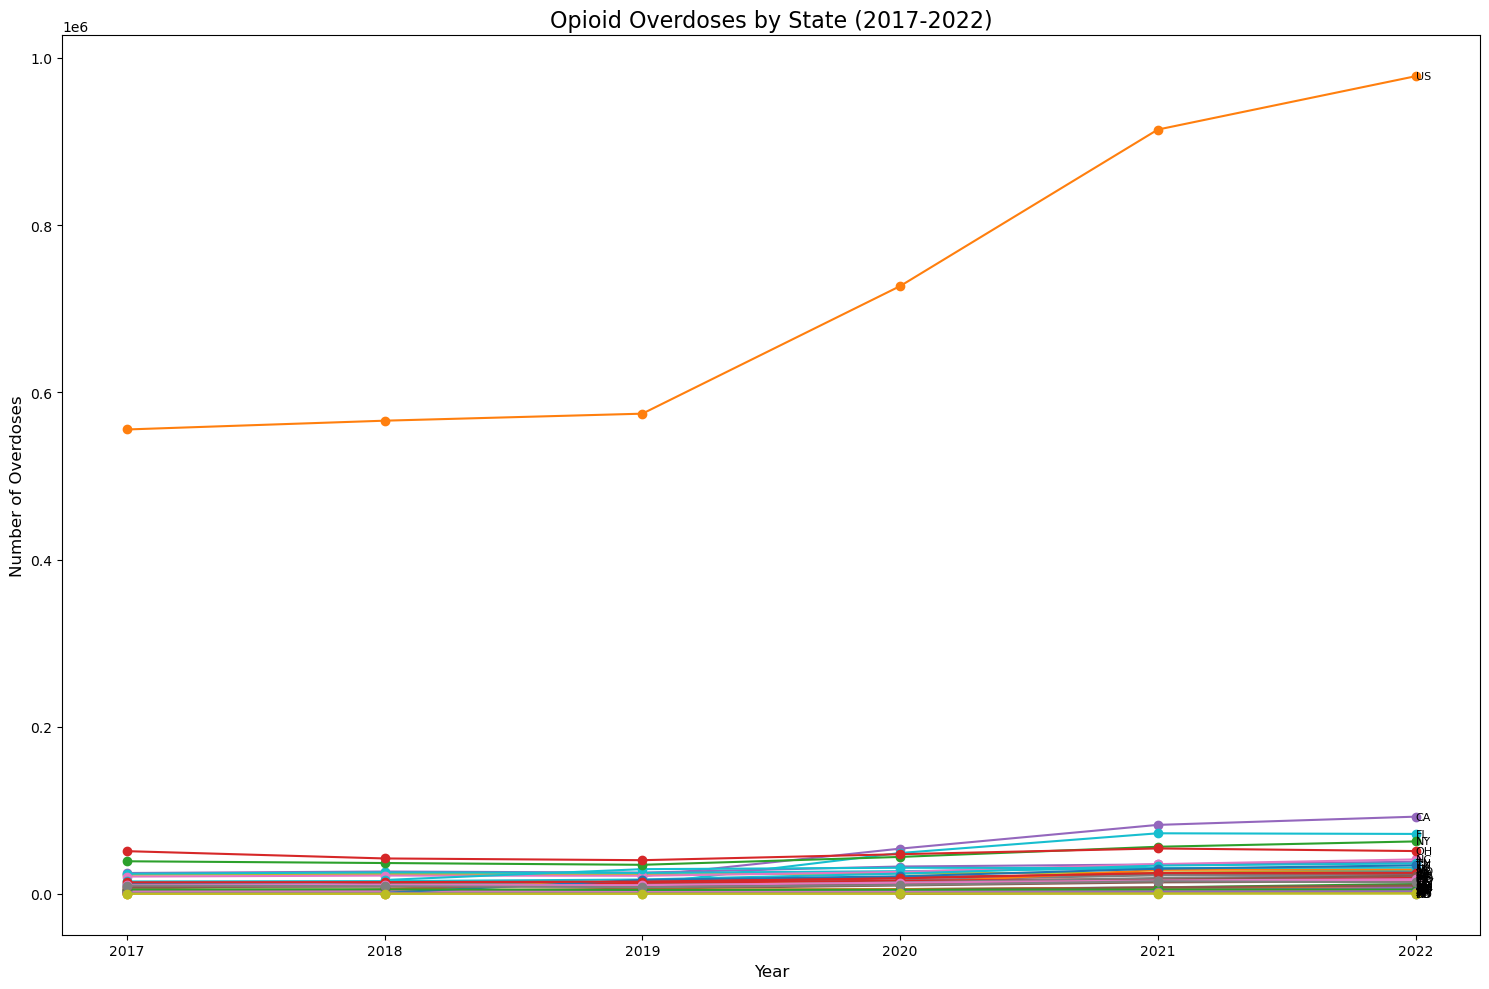

In [17]:
plt.figure(figsize=(15, 10))  # Increase figure size for better visibility

# Plot each state separately and add labels
for state in filtered_data_df['State'].unique():
    state_data = filtered_data_df[filtered_data_df['State'] == state]
    plt.plot(state_data['Year'], state_data['Data Value'], marker='o', label=state)
    
    # Add state label at the end of each line
    last_year = state_data['Year'].iloc[-1]
    last_value = state_data['Data Value'].iloc[-1]
    plt.text(last_year, last_value, state, fontsize=8, ha='left', va='center')

# Remove the legend since we now have labels on the lines
plt.legend().remove()

# Add title and labels
plt.title('Opioid Overdoses by State (2017-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Overdoses', fontsize=12)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
# Create a dataframe showing opioid-related deaths occurred in all states in 2020
filtered_data = grouped_data_df[(grouped_data_df['Year'] == 2020)]

# Create a new DataFrame from the grouped data
filtered_data_df = pd.DataFrame(filtered_data)

# Display the shape of the filtered DataFrame
filtered_data

,State,Year,Data Value
5,AK,2020,1035
20,AZ,2020,20167
26,CA,2020,54231
33,CO,2020,10130
43,CT,2020,14577
53,DC,2020,4436
60,DE,2020,5132
66,FL,2020,48994
76,GA,2020,12696
85,HI,2020,696


/var/folders/06/x1qqn_713xj3fw1_jjfy1f680000gp/T/ipykernel_92911/942042814.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


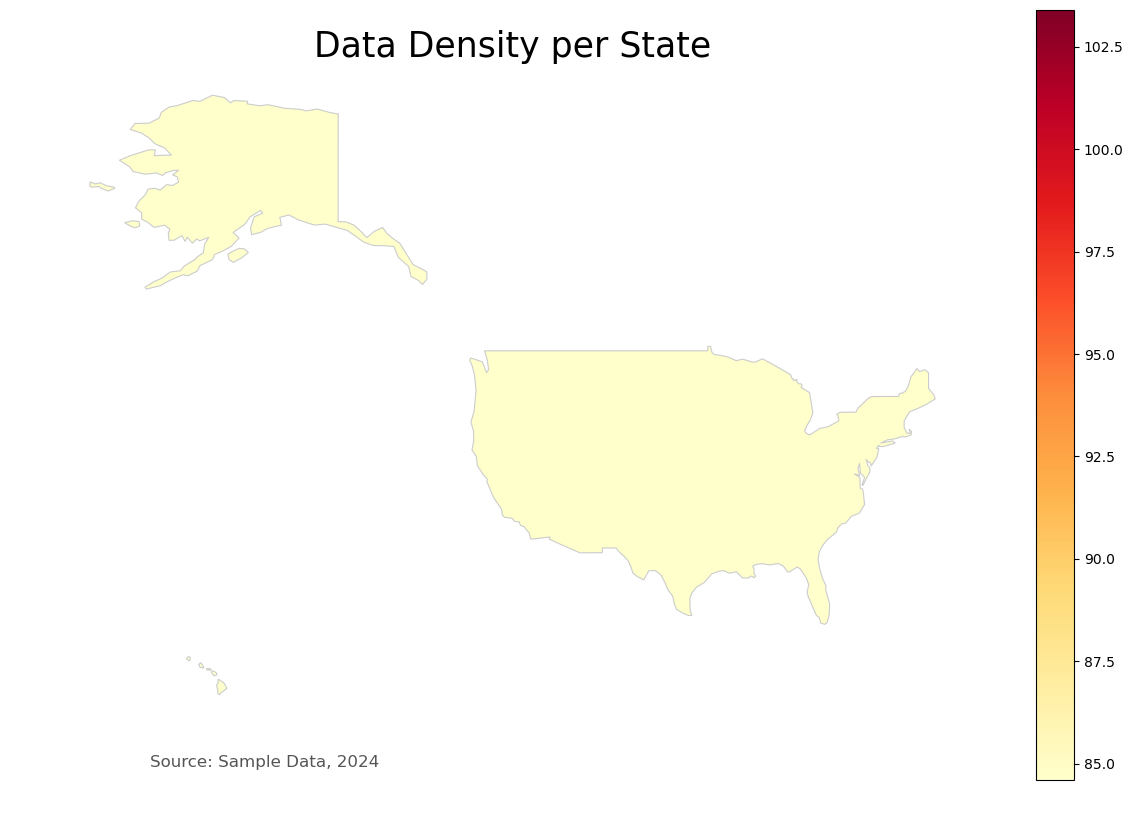

In [63]:
# Create a map of data density per state using cmap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load US states shapefile
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = us_states[us_states['continent'] == 'North America']
us_states = us_states[us_states['name'].isin(['United States of America'])]

# Create sample data for density per state
data = pd.DataFrame({
    'state': us_states.name,
    'density': np.random.randint(1, 100, len(us_states))
})

# Merge the data with the shapefile
merged = us_states.merge(data, how='left', left_on=['name'], right_on=['state'])

# Create the map
fig, ax = plt.subplots(1, figsize=(15, 10))

# Plot the data
merged.plot(column='density', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)

# Remove axis
ax.axis('off')

# Add title
ax.set_title('Data Density per State', fontdict={'fontsize': '25', 'fontweight': '3'})

# Add source annotation
ax.annotate('Source: Sample Data, 2024', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Show the plot
plt.show()


In [24]:
# Create a dataframe showing the five states with the highest rate of opioid-related death in the past ten years (2010-2020)
filtered_data = grouped_data_df[(grouped_data_df['Year'] >= 2010) & (grouped_data_df['Year'] <= 2020)]

# Create a new DataFrame from the grouped data
filtered_data_df = pd.DataFrame(filtered_data)
# Display the shape of the filtered DataFrame
filtered_data

,State,Year,Data Value
0,AK,2015,165
1,AK,2016,1163
2,AK,2017,1110
3,AK,2018,990
4,AK,2019,962
...,...,...,...
396,WV,2020,10725
401,WY,2017,404
402,WY,2018,497
403,WY,2019,508


State US needs to be removed for accurate top 5, or excluded


In [55]:
# Create a dataframe showing the five states with the highest rate of opioid-related death in the past ten years (2010-2020)
import pandas as pd

# Assuming your DataFrame is called 'filtered_data'
# and has columns 'state', 'year', and 'data_value'

# Sort the DataFrame by 'data_value' in descending order and select the top 5 rows
top_5 = filtered_data.sort_values(['Data Value'], ascending=False).head(5)

# Select only the 'state', 'year', and 'data_value' columns
result = top_5[['State', 'Year', 'Data Value']]
df = df.drop(df[df['State'] == 'US'].index)

# Display the result
print(result)

    State  Year  Data Value
336    US  2020      727063
335    US  2019      574491
334    US  2018      566097
333    US  2017      555589
332    US  2016      452369


In [16]:
# Create a line graph of the above five states, showing also the national average, in the past five years

Part 2: Correlation between opioid-related deaths and demographics

In [17]:
# Create a dataframe of opioid-related deaths and unemployment rate

In [18]:
# Create a scatter plot and run regression

In [19]:
# Create a dataframe of opioid-related deaths and education attainment

In [20]:
# Create a scatter plot and run regression

In [21]:
# Create a dataframe of opioid-related deaths and income level

In [ ]:
# Create a scatter plot and run regression ************replace XXX
x_values = XXX_df["XXX"]
y_values = combined_income_df["Median Household Income (in Inflation-Adjusted Dollars)"]

plt.scatter(x_values, y_values,
            marker="o",
            facecolors="blue",
            edgecolors="black",
            s=50,
            alpha=0.75)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (x_values.min(), y_values.max()), fontsize=15, color="red")

plt.ylim(XX, XX)
plt.xlim(XX, XX)
plt.xlabel("Opioid-related Deaths")
plt.ylabel("Median Household Income (US$)")
plt.title("Opioid-related Deaths vs. Median Household Income in 2017-2019 and 2021-2022")
plt.grid(True)

plt.savefig("output_data/Fig_Income.png")

plt.show()

In [ ]:
# 

In [23]:
# Create a dataframe of opioid-related deaths and family size

In [24]:
# Create a scatter plot and run regression

In [25]:
# ------------------------------U.S. Census demo below for reference

# U.S. Census Demo

In [26]:
# Dependencies
import requests
import pandas as pd
from census import Census

In [27]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c = Census(
    api_key,
    year = 2013
)

ModuleNotFoundError: No module named 'config'

## Retrieve data from the U.S. Census using the Census library

References:

* Review the following page to review the Python library documentation: <https://github.com/CommerceDataService/census-wrapper>

* Review the following page to learn more about the data labels: <https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b>

In [ ]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B19301_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "Name",
        "zip code tabulation area": "Zipcode"
    }
)

# Add a Poverty Rate column (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Configure the final DataFrame
census_pd = census_pd[
    [
        "Zipcode",
        "Population",
        "Median Age",
        "Household Income",
        "Per Capita Income",
        "Poverty Count",
        "Poverty Rate"
    ]
]

# Display DataFrame length and sample data
print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd.head()

In [ ]:
# Save the DataFrame as a CSV
# Note: To avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)